# Correcting the Fitting Parameters in Table 1 of CR21

In Cimerman and Rafikov 2021, the fitting parameters to $\Delta \chi$ were incorrectly estimated due to a scaling error of $2 \pi$ in the calculation of $\partial F/\partial R$. We have confirmed that rescaling their solution by $2 \pi$ gives surface density estimates as expected (see `Example.ipynb`) and in this notebook we now re-estimate the ftting paramters.

We take the 'known' correct solution of 

\begin{equation}
    f_{dep} = 2 \pi f_{\text{as written}}
\end{equation}

and use this to calculate a corrected $\Delta \chi$ and then fit a new set of the parameters $A, \tau_b, \alpha_1, \alpha_2 \text{and} \Delta$ using this.

In [1]:
!pip install h5py

In [2]:
import numpy as np
from scipy.optimize import minimize_scalar, root_scalar, curve_fit

import matplotlib.pyplot as plt

from gap_shape_python.calc_shock import *

In [3]:

def create_minimizer(p_orig):
    def func(epsilon):
        psi = (epsilon * (2 + epsilon) - 2 * (1 + epsilon) * np.log(1 + epsilon))/(2 * (1 + epsilon))
        return np.abs(p_orig - psi)
    return func

def get_epsilon(psi):
    return minimize_scalar(create_minimizer(psi), bracket=[-1e-5, 1], method='brent').x


def create_corrected_fit(p, h_p, m_p, correction=2 * np.pi):
    R = np.linspace(0.1, 5, 1000)

    tau = compute_tau_R_keplerian(R, p, h_p, m_p)

    tau_0 = 1.89 * m_p  # equation 16 in CR21
    
    def chi_func(tau, A, tau_b, alpha_1, alpha_2, delta):
        tau_squiggle = np.abs(tau - tau_0)

        return (A * (tau_squiggle/tau_b)**(-1 * alpha_1) *
                 (1 + (tau_squiggle/tau_b)**(1/delta))**(
                    (alpha_1 - alpha_2)*delta))

    
    delta_chi = compute_delta_chi(R, tau, tau_0, use_cr_21=True)
            
    epsilon_original = delta_chi * m_p * (np.abs(R**(-3/2) - 1)/(R**(1 - p) * h_p * np.sqrt(2)))**(1/2)

    psi_original = (epsilon_original * (2 + epsilon_original) - 2 * (1 + epsilon_original) * np.log(1 + epsilon_original))/(2 * (1 + epsilon_original))

    v_get_epsilon = np.vectorize(get_epsilon)

    new_epsilon_scaled = v_get_epsilon(psi_original * correction)

    delta_chi_new = new_epsilon_scaled/(m_p * (np.abs(R**(-3/2) - 1)/(R**(1 - p) * h_p * np.sqrt(2)))**(1/2))

    inner_tau = tau[R < 1]
    inner_chi = delta_chi_new[R < 1][inner_tau > tau_0]
    inner_tau = inner_tau[inner_tau > tau_0]

    outer_tau = tau[R > 1]
    outer_chi = delta_chi_new[R > 1][outer_tau > tau_0]
    outer_tau = outer_tau[outer_tau > tau_0]
    
    # Refit Table 1 values based on this

    # [2.07, 0.300, -10.84, 0.505, 0.623]
    popt_inner, pcov = curve_fit(chi_func, inner_tau, inner_chi,
                           # Use the CR21 fit as input
                            p0 = [2.07, 0.300, -10.84, 0.505, 0.623])
    print('inner', popt_inner)
    print(np.diagonal(pcov)**(1/2))

    popt_outer, pcov = curve_fit(chi_func, outer_tau, outer_chi,
                           # Use the CR21 fit as input
                            p0 = [3.11, 0.181, -8.63, 0.525, 0.766])
    print('outer', popt_outer)
    print(np.diagonal(pcov)**(1/2))
    # Recalculate everything based on these values to compare
    
    alternative_fit = {'inner': popt_inner, 'outer': popt_outer}
    
    delta_chi_new_2 = compute_delta_chi(R, tau, tau_0, False, alternative_fit)

    epsilon = delta_chi_new_2 * m_p * (np.abs(R**(-3/2) - 1)/(R**(1 - p) * h_p * np.sqrt(2)))**(1/2)
    
    psi = (epsilon * (2 + epsilon) - 2 * (1 + epsilon) * np.log(1 + epsilon))/(2 * (1 + epsilon))

    
    plt.plot(R, psi_original * correction)
    plt.plot(R, psi)
    
    plt.figure()
    plt.plot(tau, delta_chi)
    plt.plot(tau, delta_chi_new, label='rescaled')
    plt.plot(tau, delta_chi_new_2, '--', label='re-fit')
    
    plt.legend()
    
    return alternative_fit


In [4]:
import athena_read
from scipy.integrate import cumulative_trapezoid
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, root_scalar, curve_fit

from gap_shape_python.calc_shock import *

def extract_angular_momentum(filename, p, h_p, m_p, out3_file):
    GM  = 1
    eps = 0.6
    p0_over_r0 = h_p**2
    tslope = 0
    phipl0 = 3.14159
    radpl  = 1 
    
    file = athena_read.athdf(filename)
    
    rad = file['x1v']
    
    # extract F_j 
    _, f_j = calculate_f_j(file)
    
    # extract T
    # dTdr = calculate_dTdr(file, phipl0, radpl, m_p, eps, p0_over_r0, GM)
    
    dTdr = extract_dTdr(out3_file)

    # compute final things 
    df_dep = np.gradient(f_j)/np.gradient(rad) - dTdr
    F_dep  = f_j - cumulative_trapezoid(dTdr, rad, initial=0)
    return rad, f_j, dTdr, F_dep, df_dep


def calculate_dTdr(a, phipl0, radpl, GM_p, eps, p0_over_r0, GM):
    rad = a['x1v']
    phi = a['x2v']
    
    # time to make these 2d (ish) to ease the calculation
    rad = np.outer(np.ones(a['x2v'].shape), rad)
    phi = np.outer(phi, np.ones(a['x1v'].shape))

    time = a['Time']

    # r0 = 1
    omegap = np.sqrt((GM + GM_p))

    rsm = eps*np.sqrt(p0_over_r0)/omegap;
    rsm2 = rsm*rsm;
    rsm4 = rsm2*rsm2;

    radpl = 1
    radpl2 = radpl * radpl;
    phipl = phipl0 + time*omegap;
    
    # stolen from SourcePlanet in this file
    # https://github.com/cordwella/disk-with-slurm/blob/main/athena_custom/src/pgen/my_diskplanet.cpp

    dr2 = rad*rad - 2. * rad * radpl * np.cos(phi - phipl) + radpl2
    dr2prsm2 = dr2+rsm2
    i32 = 1. / dr2prsm2 / np.sqrt(dr2prsm2)
    
    smth = i32 * (1.5 * (dr2 + 1.5 * rsm2) / dr2prsm2 - 1.) # Smoothing function

    dPhidphi = 1 * GM_p*2.*rad*radpl*np.sin(phi-phipl)*smth;
    
    dtdrdphi = dPhidphi * a['dens'][0] * rad
    
    return np.trapz(dtdrdphi, axis=0, x=phi)

def extract_dTdr(filename):
    test = athena_read.athdf(filename)

    total_phi = test['RootGridSize'][1]

    # Get the force on each unit cell and integrate then multiply by R^2
    # dphi = 2 pi/total_phi
    dt2 = np.sum(test['plntsrcmom2'][0], axis=0)/total_phi * test['x1v']**2 * 2 * np.pi

    return dt2


def calculate_f_j(a):
    # Use omega_0 as the pressure supported value 
    R = a['x1v']
    phi = a['x2v']
    sigma = a['dens'][0] # 0 to get the 2d values

    sigma_radial_average = np.average(sigma, axis=0) # Axis 0 is phi direction
    u_phi = a['mom2'][0]/sigma
    
    u_phi_0 = np.average(a['mom2'][0], axis=0)/sigma_radial_average
    
    d_u_phi = u_phi - u_phi_0
    u_r = a['mom1'][0]/sigma
    f_j = R**2 * np.trapz(sigma * u_r * (u_phi - u_phi_0), axis=0, x=phi)
    
    return R, f_j



/tmp/ipykernel_563/2655077148.py:3: RuntimeWarning: invalid value encountered in log
  psi = (epsilon * (2 + epsilon) - 2 * (1 + epsilon) * np.log(1 + epsilon))/(2 * (1 + epsilon))


inner [ 3.64447063  0.41486091 -7.75264931  0.51830383  0.59109359]
[0.02656137 0.00523432 0.11843553 0.00024359 0.00144816]
outer [ 4.99262939  0.29350545 -5.74964165  0.53780626  0.70719867]
[0.02240955 0.00224105 0.04446242 0.00010212 0.0009444 ]


(0.0, 40.0)

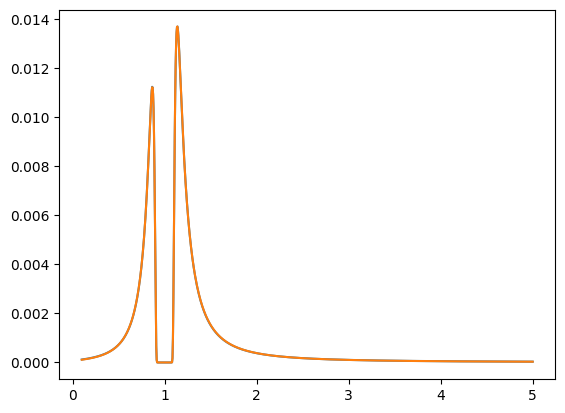

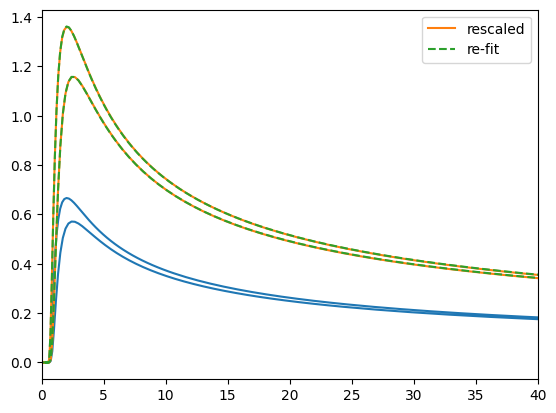

In [5]:
create_corrected_fit(1.5, 0.05, 0.25)
plt.xlim([0, 40])

In [6]:
def create_minimizer(p_orig):
    def func(epsilon):
        psi = (epsilon * (2 + epsilon) - 2 * (1 + epsilon) * np.log(1 + epsilon))/(2 * (1 + epsilon))
        return np.abs(p_orig - psi)
    return func

def get_epsilon(psi):
    return minimize_scalar(create_minimizer(psi), bracket=[-1e-5, 1], method='brent').x

v_get_epsilon = np.vectorize(get_epsilon)

def create_corrected_fit_multiple(params, correction=1, m_p_power=1.083):
    R = np.logspace(np.log10(0.1), np.log10(5), 4000)

    outer_t_s = []
    inner_t_s = []
    outer_chis = []
    inner_chis = []

    para        = params[0]
    p, h_p, m_p = para

    tau = compute_tau_R_keplerian(R, p, h_p, m_p)

    tau_0 = 1.89 * m_p  # equation 16 in CR21

    def chi_func(tau_squiggle, A, tau_b, alpha_1, alpha_2, delta):
        # tau_squiggle = np.abs(tau - tau_0)

        return (A * (tau_squiggle/tau_b)**(-1 * alpha_1) *
                 (1 + (tau_squiggle/tau_b)**(1/delta))**(
                    (alpha_1 - alpha_2)*delta))

    delta_chi = compute_delta_chi(R, tau, tau_0, use_cr_21=True)

    epsilon_original = delta_chi * m_p * (np.abs(R**(-3/2) - 1)/(R**(1 - p) * h_p * np.sqrt(2)))**(1/2)

    psi_original = (epsilon_original * (2 + epsilon_original) - 2 * (1 + epsilon_original) * np.log(1 + epsilon_original))/(2 * (1 + epsilon_original))

    new_epsilon_scaled = v_get_epsilon(psi_original * correction)

    background = new_epsilon_scaled/(m_p                            
            * (np.abs(R**(-3/2) - 1)/(R**(1 - p) * h_p * np.sqrt(2)))**(1/2))
    
    background_tau_min = (tau - tau_0)

    for i in range(len(params)):
        para        = params[i]
        p, h_p, m_p = para

        tau = compute_tau_R_keplerian(R, p, h_p, m_p)

        tau_0 = 1.89 * m_p  # equation 16 in CR21

        def chi_func(tau_squiggle, A, tau_b, alpha_1, alpha_2, delta):
            # tau_squiggle = np.abs(tau - tau_0)

            return (A * (tau_squiggle/tau_b)**(-1 * alpha_1) *
                     (1 + (tau_squiggle/tau_b)**(1/delta))**(
                        (alpha_1 - alpha_2)*delta))

        delta_chi = compute_delta_chi(R, tau, tau_0, use_cr_21=True)

        epsilon_original = delta_chi * m_p * (np.abs(R**(-3/2) - 1)/(R**(1 - p) * h_p * np.sqrt(2)))**(1/2)

        psi_original = (epsilon_original * (2 + epsilon_original) - 2 * (1 + epsilon_original) * np.log(1 + epsilon_original))/(2 * (1 + epsilon_original))
        
        new_epsilon_scaled = v_get_epsilon(psi_original * correction)
        
        delta_chi_new = new_epsilon_scaled/(m_p**(m_p_power)                            
                * (np.abs(R**(-3/2) - 1)/(R**(1 - p) * h_p * np.sqrt(2)))**(1/2))

        tau = compute_tau_R_keplerian(R, p, h_p, m_p)
        tau_0 = 1.89 * m_p  # equation 16 in CR21

        # plt.plot((tau - tau_0)[R > 1], delta_chi_new[R > 1], label='' + str(para))
        # plt.plot((tau - tau_0), delta_chi_new/np.interp(tau - tau_0, background_tau_min, background), label='' + str(para))
        plt.plot((tau - tau_0), delta_chi_new, label='' + str(para))
        
        # plt.plot((tau - tau_0)[R < 1], delta_chi_new[R < 1], '--', label='' + str(para))

        inner_tau = tau[R < 1]
        inner_chi = delta_chi_new[R < 1][inner_tau > tau_0]
        inner_tau = inner_tau[inner_tau > tau_0]

        outer_tau = tau[R > 1]
        outer_chi = delta_chi_new[R > 1][outer_tau > tau_0]
        outer_tau = outer_tau[outer_tau > tau_0]

        # Refit Table 1 values based on this
        
        outer_t_s.append(outer_tau - tau_0)
        inner_t_s.append(inner_tau - tau_0)
        outer_chis.append(outer_chi)
        inner_chis.append(inner_chi)

    inner_tau = np.concatenate(inner_t_s)
    outer_tau = np.concatenate(outer_t_s)
    
    inner_chi = np.concatenate(inner_chis)
    outer_chi = np.concatenate(outer_chis)
    
    popt_inner, pcov = curve_fit(
                           chi_func, inner_tau, inner_chi,
                           #sigma=np.log(inner_tau)/10,
                            # Use the CR21 fit as input
        p0 =[ 1.2813751,   1.78980705, -0.41996084,  0.46560578,  0.31017843])
        #p0 = [2.07, 0.300, -10.84, 0.505, 0.623])
    print('inner', popt_inner)

    popt_outer, pcov = curve_fit(chi_func, outer_tau, outer_chi,
                           # Use the CR21 fit as input
                            #sigma=np.log(outer_tau)/10,
                            p0 = [ 1.47424686,  1.18349286, -0.4937191,   0.41158479,  0.18393413])
                            # p0 = [3.11, 0.181, -8.63, 0.525, 0.766])
    print('outer', popt_outer)
    
    # Recalculate everything based on these values to compare
    alternative_fit = {'inner': popt_inner, 'outer': popt_outer}

    for para in params[:1]:
        p, h_p, m_p = para
        
        tau = compute_tau_R_keplerian(R, p, h_p, m_p)

        tau_0 = 1.89 * m_p  # equation 16 in CR21
        delta_chi = compute_delta_chi(R, tau, tau_0, False, alternative_fit)
        epsilon = delta_chi * m_p**(m_p_power) * (np.abs(R**(-3/2) - 1)/(R**(1 - p) * h_p * np.sqrt(2)))**(1/2)

        psi = (epsilon * (2 + epsilon) - 2 * (1 + epsilon) * np.log(1 + epsilon))/(2 * (1 + epsilon))

        # plt.plot(tau - tau_0, delta_chi/np.interp(tau - tau_0, background_tau_min, background), '--', label='New Fit')
        plt.plot(tau - tau_0, delta_chi, '--', label='New Fit')

    return alternative_fit


# In this case here the differences between the lines are functions of M_p only

In [7]:
def plot_chi_from_file(params, files, out3_files, power):
    for i in range(len(params)):
        para        = params[i]
        filename    = files[i]
        out3_file   = out3_files[i]
        
        p, h_p, m_p = para
        
        R, f_j, dTdr, F_dep, df_dep = extract_angular_momentum(filename, p, h_p, m_p, out3_file)
        
        # plt.plot(R, f_j * m_p**(-2), label='original' + str(para))
        # plt.plot(R, df_dep * m_p**(-2), label='original' + str(para))

        # f_R = * psi
        # TODO: correct <Sigma>
        a = athena_read.athdf(filename)

        sigma = a['dens'][0] # 0 to get the 2d values

        sigma_radial_average = np.average(sigma, axis=0) # Axis 0 is phi direction
        
        psi = - df_dep/(np.sign(1 - R**(-3/2)) * 1 * R * h_p**2 * sigma_radial_average)

        new_epsilon_scaled = v_get_epsilon(psi)
        
        delta_chi_new = new_epsilon_scaled/(m_p**(power)                            
                * (np.abs(R**(-3/2) - 1)/(R**(1 - p) * h_p * np.sqrt(2)))**(1/2))

        tau = compute_tau_R_keplerian(R, p, h_p, m_p)
        tau_0 = 1.89 * m_p  # equation 16 in CR21

        plt.plot((tau - tau_0), delta_chi_new, label='A++ ' + str(para))


1


/tmp/ipykernel_563/984686432.py:3: RuntimeWarning: invalid value encountered in log
  psi = (epsilon * (2 + epsilon) - 2 * (1 + epsilon) * np.log(1 + epsilon))/(2 * (1 + epsilon))


inner [ 3.57028812  0.42035281 -7.6073482   0.51593287  0.58943579]
outer [ 5.17813033  0.27312773 -6.11205709  0.53788222  0.72002135]
1.06
inner [ 4.03092495  0.40599359 -7.89898822  0.51722142  0.5938736 ]
outer [ 5.91511265  0.25978213 -6.38853661  0.53973503  0.72712499]
1.065
inner [ 4.07231499  0.40479596 -7.92434118  0.51732857  0.59424454]
outer [ 5.98188823  0.25867235 -6.41277514  0.53988943  0.72772042]
1.07
inner [ 4.11419543  0.40359823 -7.94986205  0.51743569  0.59461564]
outer [ 6.04954612  0.25756298 -6.43720756  0.54004382  0.72831636]
1.0725
inner [ 4.13532002  0.40299958 -7.96267966  0.51748922  0.59480118]
outer [ 6.08370998  0.25700846 -6.44949709  0.54012101  0.72861452]
1.075
inner [ 4.15657039  0.40240077 -7.97554296  0.51754275  0.59498679]
outer [ 6.118099    0.25645406 -6.4618353   0.54019819  0.72891279]


/tmp/ipykernel_563/984686432.py:58: RuntimeWarning: invalid value encountered in power
  return (A * (tau_squiggle/tau_b)**(-1 * alpha_1) *
/tmp/ipykernel_563/984686432.py:59: RuntimeWarning: invalid value encountered in power
  (1 + (tau_squiggle/tau_b)**(1/delta))**(


1.08
inner [ 4.19945215  0.40120267 -8.00140891  0.51764978  0.59535825]
outer [ 6.18756247  0.25534547 -6.48666446  0.54035256  0.72950978]
1.085
inner [ 4.24283818  0.40000536 -8.02742476  0.51775674  0.59572961]
outer [ 6.25794362  0.25423764 -6.51168604  0.5405069   0.73010714]
1.09
inner [ 4.28674532  0.39880727 -8.05363284  0.51786368  0.59610131]
outer [ 6.32926153  0.25313021 -6.53691157  0.54066123  0.73070501]
1.095
inner [ 4.33117424  0.39760936 -8.08001036  0.51797057  0.59647309]
outer [ 6.40152967  0.25202325 -6.5623424   0.54081553  0.73130337]
1.1
inner [ 4.3761322   0.39641156 -8.10656053  0.51807739  0.59684495]
outer [ 6.47475803  0.25091703 -6.58797371  0.54096981  0.73190209]
1.15
inner [ 4.85640788  0.3844381  -8.38200048  0.51914247  0.60056893]
outer [ 7.26326479  0.23989002 -6.85603838  0.54251063  0.73791228]


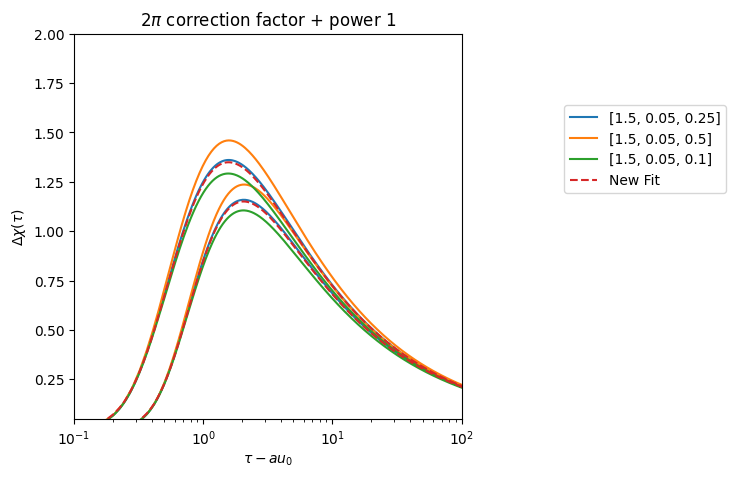

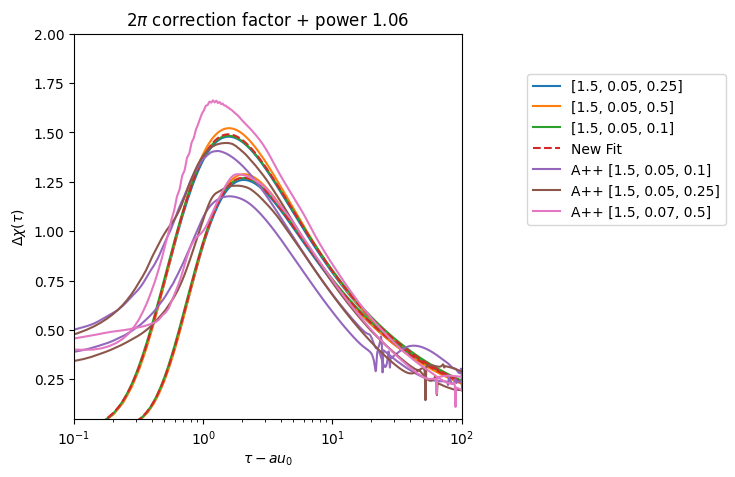

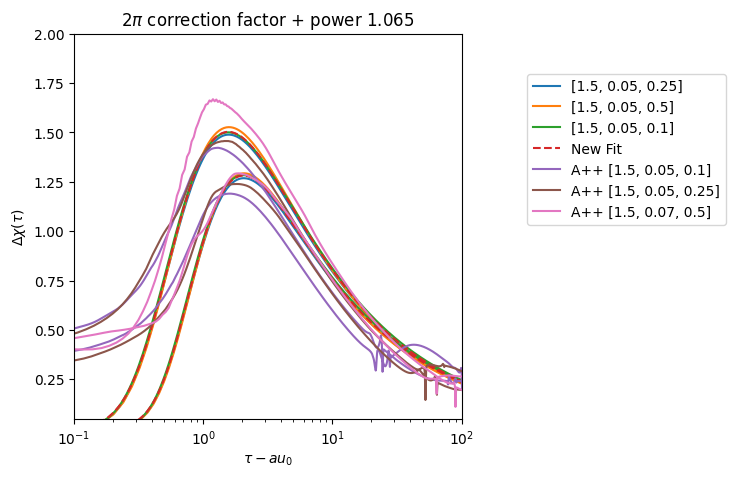

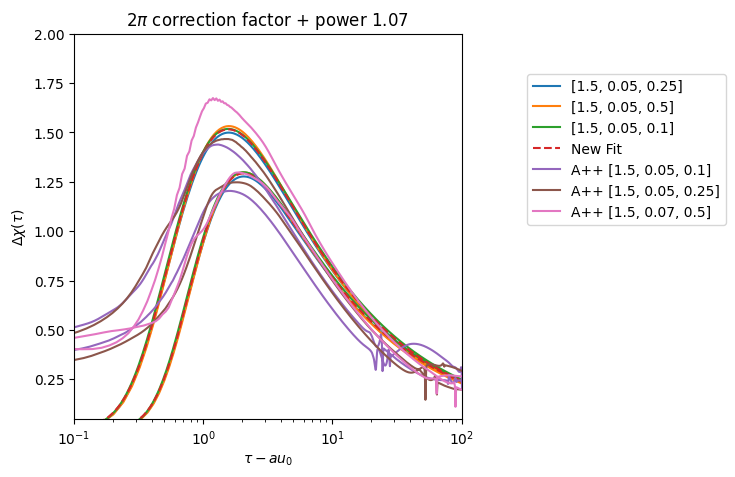

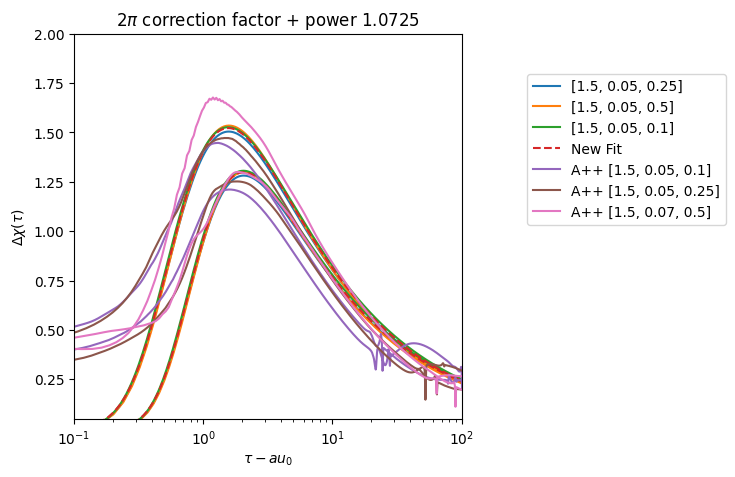

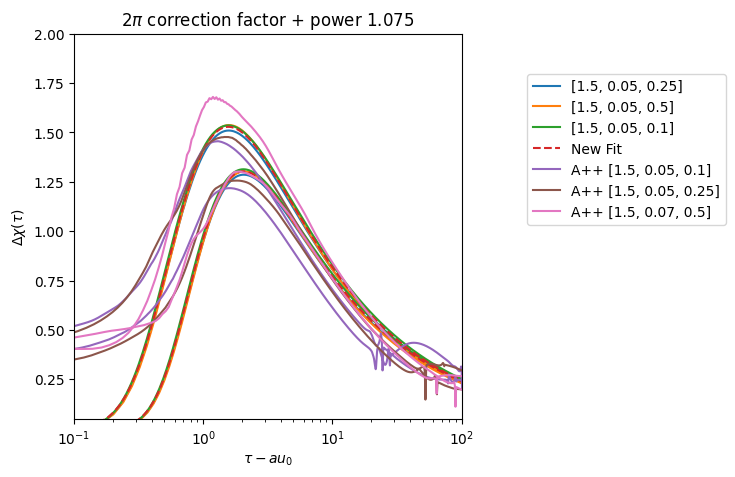

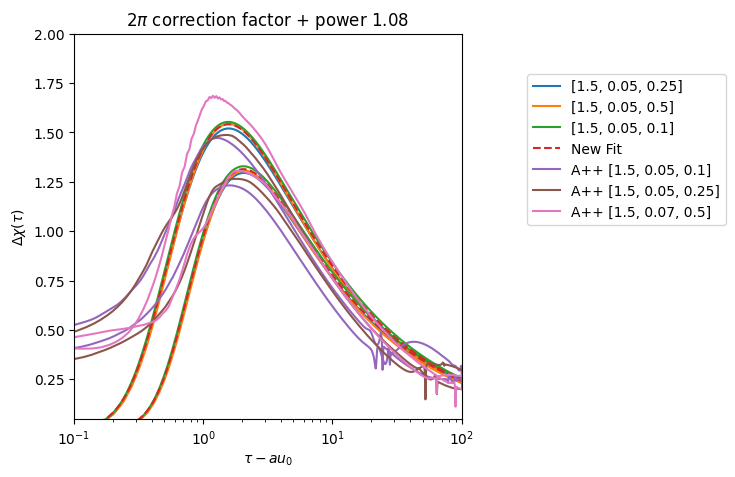

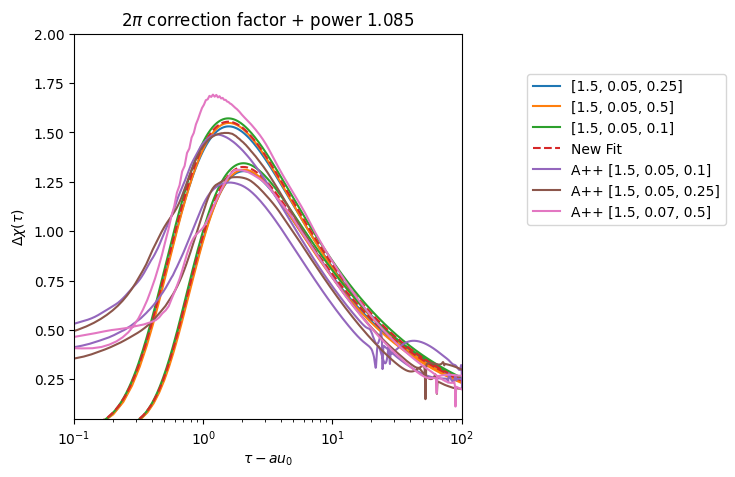

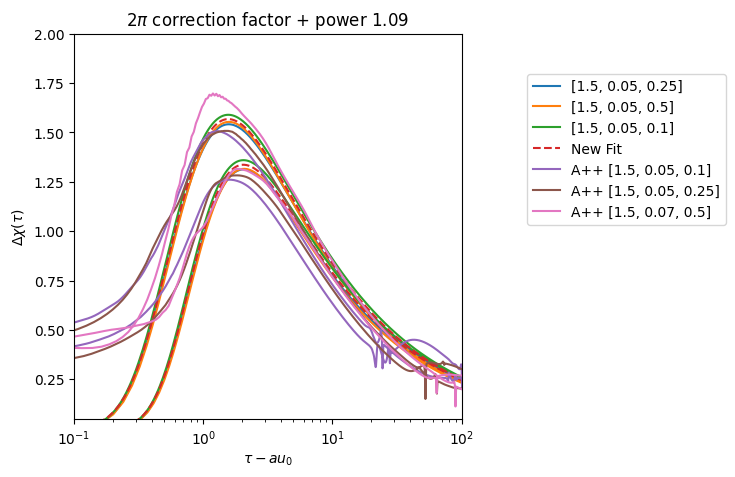

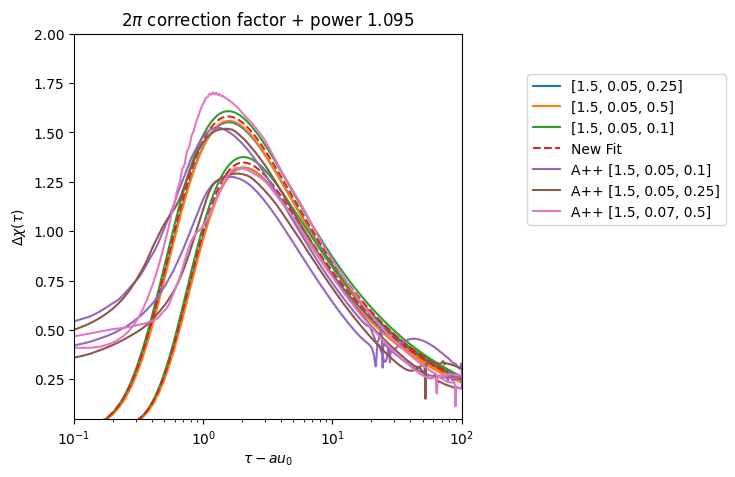

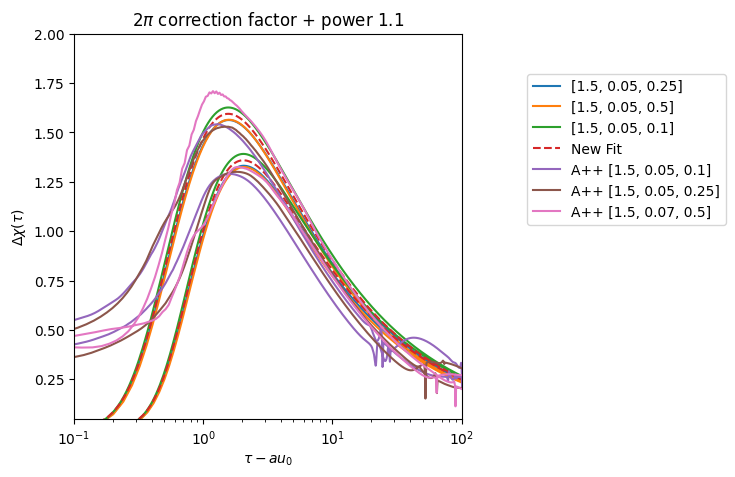

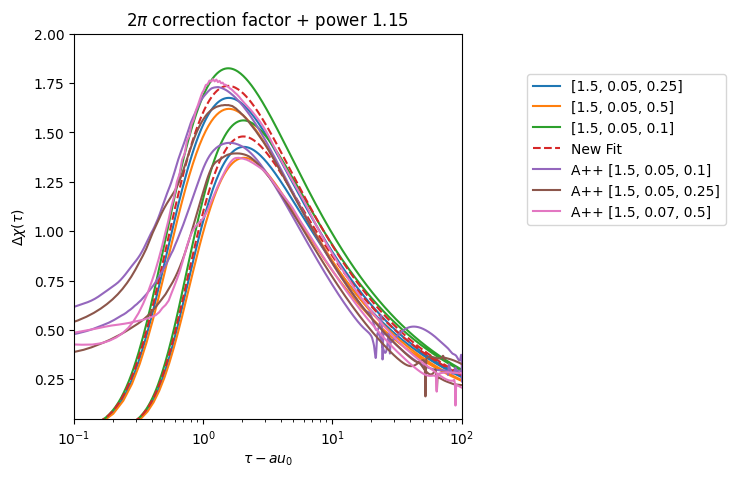

In [8]:

for power in [1, 1.06, 1.065, 1.07, 1.0725,  1.075, 1.08, 1.085, 1.09, 1.095, 1.10, 1.15]:
    print(power)
    plt.figure(figsize=(5, 5))

    create_corrected_fit_multiple( [
        # [1.5, 0.05, 0.05], [1.5, 0.1, 0.05], [1.5, 0.07, 0.05], 
        #[1.5, 0.05, 0.05], 
        [1.5, 0.05, 0.25], [1.5, 0.05, 0.5], [1.5, 0.05, 0.1], 
        # [1.5, 0.05, 0.75], [1.5, 0.10, 0.75], [1.5, 0.07, 0.75],
    ], correction=(2 * np.pi), m_p_power=power)
    # plt.loglog()
    
    if power != 1:
        plot_chi_from_file(
            [[1.5, 0.05, 0.1], 
             [1.5, 0.05, 0.25], 
             [1.5, 0.07, 0.5],
             #[1.5, 0.05, 0.5],
            ],
            [
             'fitting_correction_data/ISO-f-sm-0.1Mh05-q1.5_o2_19.out1.00100.athdf',
            'fitting_correction_data/ISO-f-sm-0.25Mh05-q1.5_o2_19.out1.00020.athdf',
            'fitting_correction_data/ISO-f-sm-0.5Mh07-q1.5_o2_19.out1.00020.athdf',
            #'fitting_correction_data/ISO-f-sm-0.5Mh05-q1.5_o2_19.out1.00010.athdf',
            ],
            ['fitting_correction_data/ISO-f-sm-0.1Mh05-q1.5_o2_19.out3.01000.athdf',
            'fitting_correction_data/ISO-f-sm-0.25Mh05-q1.5_o2_19.out3.00200.athdf',
            'fitting_correction_data/ISO-f-sm-0.5Mh07-q1.5_o2_19.out3.00200.athdf',
            #'fitting_correction_data/ISO-f-sm-0.5Mh05-q1.5_o2_19.out3.00100.athdf',
            ], power
        )
    
    plt.gca().set_xscale('log')
    plt.xlim([0.1, 100])
    plt.legend()
    plt.ylim([0.05, 2])

    plt.title('$2 \pi$ correction factor + power {}'.format(power))
    # plt.loglog()
    plt.xlabel('$\\tau - \tau_0$')
    plt.ylabel('$\Delta \chi(\\tau)$')
    plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.7))
    plt.gca().set_xscale('log')

    # In this case here the differences between the lines are functions of M_p only

/tmp/ipykernel_563/984686432.py:3: RuntimeWarning: invalid value encountered in log
  psi = (epsilon * (2 + epsilon) - 2 * (1 + epsilon) * np.log(1 + epsilon))/(2 * (1 + epsilon))


inner [  2.56448798   0.26673017 -12.38572435   0.50888332   0.63474918]
outer [  4.02461469   0.15177304 -10.13397867   0.53067958   0.78561235]


Text(0, 0.5, '$\\Delta \\chi(\\tau)$')

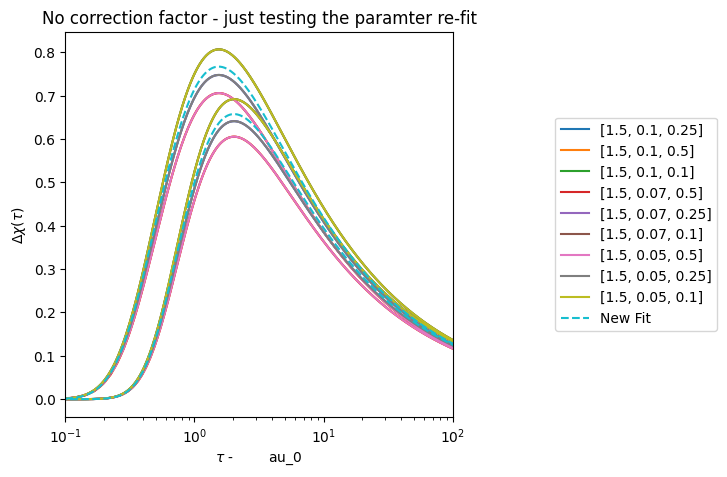

In [9]:
plt.figure(figsize=(5, 5))

create_corrected_fit_multiple( [
    # [1.5, 0.05, 0.05], [1.5, 0.1, 0.05], [1.5, 0.07, 0.05], 
    [1.5, 0.1, 0.25], [1.5, 0.1, 0.5], [1.5, 0.1, 0.1], 
    [1.5, 0.07, 0.5], [1.5, 0.07, 0.25], [1.5, 0.07, 0.1],
    [1.5, 0.05, 0.5], [1.5, 0.05, 0.25], [1.5, 0.05, 0.1],
    # [1.5, 0.05, 0.75], [1.5, 0.10, 0.75], [1.5, 0.07, 0.75],
], 1)
# plt.loglog()
plt.gca().set_xscale('log')
plt.xlim([0.1, 100])
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5))

plt.title('No correction factor - just testing the paramter re-fit')
plt.xlabel('$\\tau$ - \tau_0')
plt.ylabel('$\Delta \chi(\\tau)$')